In [2]:
import pandas as pd
import polars as pl
import os

TRAIN_FUEL = pl.read_parquet(os.path.join('data',"postprocessed","training", 'TRAIN_CLEAN_v4.parquet'))
SUB_FUEL = pl.read_parquet(os.path.join('data',"postprocessed","training", 'SUB_CLEAN_v3.parquet'))
FINAL_FUEL = pl.read_parquet(os.path.join("data","postprocessed","training", 'TRAIN_FINAL_v1.parquet'))
df_train = TRAIN_FUEL
df_sub = SUB_FUEL
df_final = FINAL_FUEL


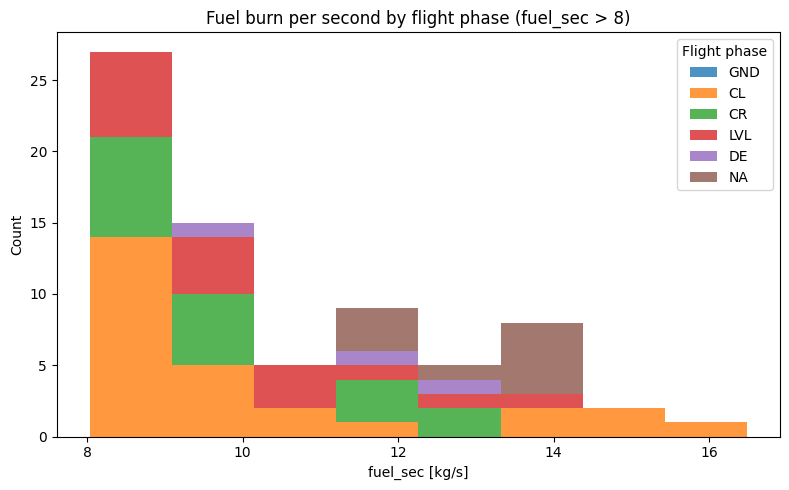

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Compute duration in seconds
dur_seconds = (
    (df_train["segment_end"] - df_train["segment_start"])
      .dt.cast_time_unit("ms")
      .cast(pl.Float64) / 1_000.0
)

fuel_consumption = df_train["fuel_kg"]

fuel_per_sec = fuel_consumption.to_numpy()
duration_per_sec = dur_seconds.to_numpy()

# Base mask: avoid division by zero
mask = duration_per_sec > 0

fuel_per_sec = fuel_per_sec[mask]
duration_per_sec = duration_per_sec[mask]

fuel_sec = fuel_per_sec / duration_per_sec

# Phases aligned with base mask
phases = df_train["flightphase_dominant"].to_numpy()
phases = phases[mask]

# ---- FILTER: fuel_sec > 3 (change threshold as you like) ----
threshold = 8

filter_mask = fuel_sec > threshold

fuel_sec_filtered = fuel_sec[filter_mask]
phases_filtered = phases[filter_mask]

# Define the phase categories (order them as you like)
phase_order = ["GND", "CL", "CR", "LVL","DE","NA"]

# Extract values per phase AFTER filtering
fuel_by_phase = [fuel_sec_filtered[phases_filtered == ph] for ph in phase_order]

# Choose common bins for all phases
bins = np.linspace(fuel_sec_filtered.min(), fuel_sec_filtered.max(), 9)

fig, ax = plt.subplots(figsize=(8,5))

ax.hist(
    fuel_by_phase,
    bins=bins,
    stacked=True,
    label=phase_order,
    alpha=0.8
)

ax.set_title(f"Fuel burn per second by flight phase (fuel_sec > {threshold})")
ax.set_xlabel("fuel_sec [kg/s]")
ax.set_ylabel("Count")
ax.legend(title="Flight phase")

plt.tight_layout()
plt.show()


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

def plot_aircraft_count_by_wake_only(
    df: pl.DataFrame,
    selected_wakes: list[str] | None = None,
):
    """
    Plot the number of rows (aircraft/segments) per wake category.

    Parameters
    ----------
    df : pl.DataFrame
        Must contain column 'wake'.
    selected_wakes : list of str, optional
        Which wake categories to include, e.g. ['L', 'M'].
        If None or empty, all wake categories in the data are used.
    """

    wakes = df["wake"].to_numpy()

    # if no specific wakes provided, use all unique wakes
    if not selected_wakes:
        selected_wakes = sorted(np.unique(wakes))

    # filter to selected wakes
    mask = np.isin(wakes, selected_wakes)
    wakes_f = wakes[mask]

    if len(wakes_f) == 0:
        print("No data for the selected wake categories:", selected_wakes)
        return

    # count per wake
    unique_wakes = []
    counts = []
    for w in selected_wakes:
        c = np.sum(wakes_f == w)
        if c > 0:
            unique_wakes.append(w)
            counts.append(c)

    fig, ax = plt.subplots(figsize=(6, 4))

    ax.bar(unique_wakes, counts)
    ax.set_xlabel("Wake category")
    ax.set_ylabel("Number of aircraft (rows)")
    ax.set_title("Count per wake category")

    # annotate counts on the bars
    for x, c in zip(unique_wakes, counts):
        ax.text(x, c, str(c), ha="center", va="bottom")

    plt.tight_layout()
    plt.show()


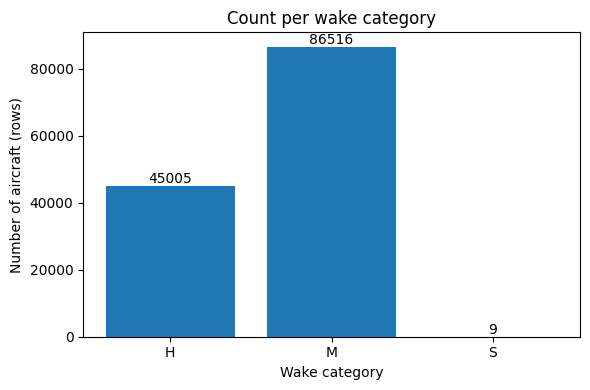

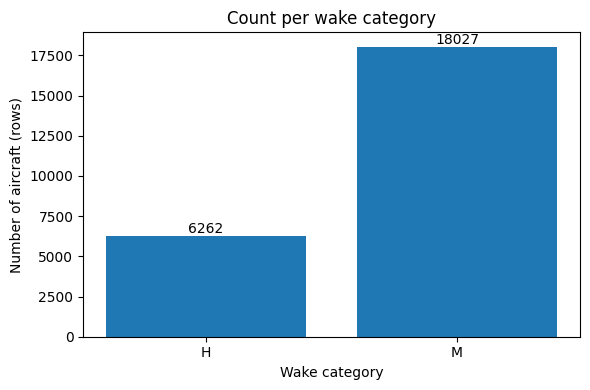

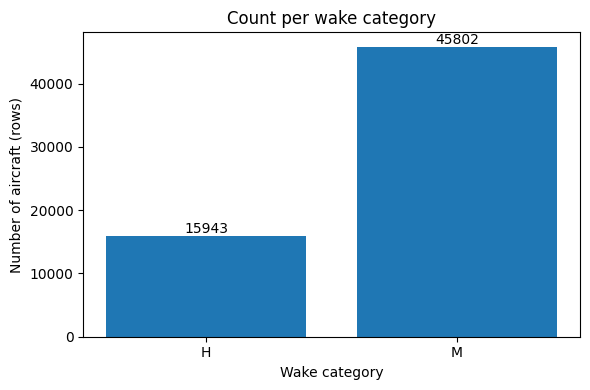

In [6]:
# All wakes in the dataset
plot_aircraft_count_by_wake_only(df_train)
plot_aircraft_count_by_wake_only(df_sub)
plot_aircraft_count_by_wake_only(df_final)



In [8]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

def plot_aircraft_count_by_wake(
    df: pl.DataFrame,
    threshold: float = 0.0,
    selected_wakes: list[str] | None = None,
) -> pl.DataFrame:
    """
    Plot the number of rows (aircraft/segments) per wake category
    after filtering by fuel_sec > threshold and by selected_wakes,
    and return the filtered rows as a Polars DataFrame.

    Parameters
    ----------
    df : pl.DataFrame
        Must contain columns:
        - 'segment_start', 'segment_end' (datetime)
        - 'fuel_kg'
        - 'wake'
        - 'flight_id' (or any other columns you need)
    threshold : float, optional
        Minimum fuel_sec (kg/s) to keep, default 0.0.
    selected_wakes : list of str, optional
        Which wake categories to include, e.g. ['L', 'M'].
        If None or empty, all wake categories in the data are used.

    Returns
    -------
    pl.DataFrame
        Filtered dataframe containing all rows that match the selection.
    """

    # ---- add duration and fuel_sec columns ----
    df2 = (
        df.with_columns(
            (
                (pl.col("segment_end") - pl.col("segment_start"))
                .dt.cast_time_unit("ms")
                .cast(pl.Float64) / 1_000.0
            ).alias("duration_s")
        )
        .with_columns(
            (pl.col("fuel_kg") / pl.col("duration_s")).alias("fuel_sec")
        )
        .filter(pl.col("duration_s") > 0)  # avoid division by zero
    )

    # If no wakes specified, use all wakes present after duration filter
    if not selected_wakes:
        selected_wakes = (
            df2.select(pl.col("wake").unique())
               .to_series()
               .to_list()
        )
        selected_wakes = sorted(selected_wakes)

    # ---- apply filters: fuel_sec + wake ----
    df_filtered = df2.filter(
        (pl.col("fuel_sec") > threshold) &
        (pl.col("wake").is_in(selected_wakes))
    )

    if df_filtered.height == 0:
        print("No data left after applying filters.")
        return df_filtered

    # ---- count per wake for plotting ----
    counts_df = (
        df_filtered
        .group_by("wake")
        .len()             # creates column 'len'
    )

    # keep order consistent with selected_wakes, only those that exist
    counts_dict = dict(zip(counts_df["wake"].to_list(),
                           counts_df["len"].to_list()))
    unique_wakes = [w for w in selected_wakes if w in counts_dict]
    counts = [counts_dict[w] for w in unique_wakes]

    # ---- plot bar chart ----
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.bar(unique_wakes, counts)
    ax.set_xlabel("Wake category")
    ax.set_ylabel("Number of aircraft (rows)")
    ax.set_title(f"Count per wake (fuel_sec > {threshold})")

    # annotate counts on top of bars
    for x, c in zip(unique_wakes, counts):
        ax.text(x, c, str(c), ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

    # Return full rows that match selection
    return df_filtered


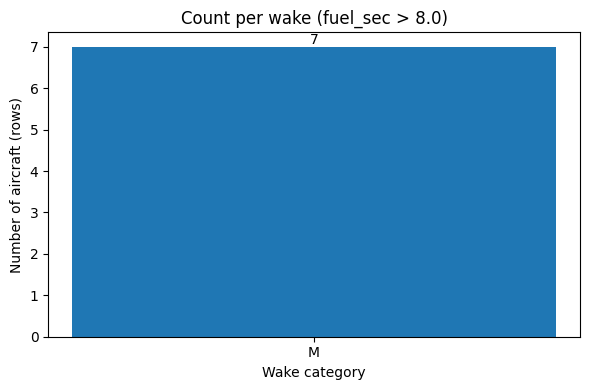

shape: (5, 64)
┌─────────────┬──────────┬────────┬──────────┬───┬────────────┬────────────┬────────────┬──────────┐
│ flight_id   ┆ typecode ┆ source ┆ fuel_kg  ┆ … ┆ segment_na ┆ flightphas ┆ duration_s ┆ fuel_sec │
│ ---         ┆ ---      ┆ ---    ┆ ---      ┆   ┆ ---        ┆ e_dominant ┆ ---        ┆ ---      │
│ str         ┆ str      ┆ str    ┆ f64      ┆   ┆ f64        ┆ ---        ┆ f64        ┆ f64      │
│             ┆          ┆        ┆          ┆   ┆            ┆ str        ┆            ┆          │
╞═════════════╪══════════╪════════╪══════════╪═══╪════════════╪════════════╪════════════╪══════════╡
│ prc77376517 ┆ A320     ┆ adsb   ┆ 181.4368 ┆ … ┆ 0.0        ┆ LVL        ┆ 18.183     ┆ 9.978375 │
│ 6           ┆          ┆        ┆          ┆   ┆            ┆            ┆            ┆          │
│ prc77476333 ┆ A320     ┆ adsb   ┆ 181.4368 ┆ … ┆ 0.0        ┆ LVL        ┆ 20.106     ┆ 9.024013 │
│ 1           ┆          ┆        ┆          ┆   ┆            ┆            ┆

In [11]:
# All wake categories, with fuel_sec > 3
# plot_aircraft_count_by_wake(df_train, threshold=3.0)

# Only light & medium
# plot_aircraft_count_by_wake(df_train, threshold=7.0, selected_wakes=["M"])
filtered_rows = plot_aircraft_count_by_wake(
    df_train,
    threshold=8.0,
    selected_wakes=["M"]
)
# do assessment of low fuel_sec
print(filtered_rows.head())
print("Number of rows in selection:", filtered_rows.height)


In [12]:
filtered_rows.write_parquet(os.path.join("data", "testing", "filtered_M_rows.parquet"))

In [13]:
import matplotlib.pyplot as plt
import polars as pl

def plot_fuel_hist_for_type(
    df: pl.DataFrame,
    aircraft_type: str,
    threshold: float = 0.0,
    bins: int = 30,
) -> pl.DataFrame:
    """
    Plot a histogram of fuel_sec for a single aircraft type, colored by
    flightphase_dominant, after filtering on a fuel_sec threshold.

    Parameters
    ----------
    df : pl.DataFrame
        Must contain:
        - 'segment_start', 'segment_end' (datetime)
        - 'fuel_kg'
        - 'typecode'
        - 'flightphase_dominant' (e.g. 'CR', 'CL', 'DE', 'NA', ...)
    aircraft_type : str
        Single aircraft type to plot, e.g. "B744".
    threshold : float, optional
        Minimum fuel_sec (kg/s) to keep for the histogram. Default 0.0.
    bins : int, optional
        Number of histogram bins. Default 30.

    Returns
    -------
    pl.DataFrame
        Filtered dataframe used for the plot (only this type and
        fuel_sec > threshold).
    """

    # --- compute duration and fuel_sec ---
    df2 = (
        df.with_columns(
            (
                (pl.col("segment_end") - pl.col("segment_start"))
                .dt.cast_time_unit("ms")
                .cast(pl.Float64) / 1_000.0
            ).alias("duration_s")
        )
        .with_columns(
            (pl.col("fuel_kg") / pl.col("duration_s")).alias("fuel_sec")
        )
        .filter(pl.col("duration_s") > 0)
    )

    # --- filter for the single aircraft type ---
    df2 = df2.filter(pl.col("typecode") == aircraft_type)

    if df2.height == 0:
        print(f"No data for aircraft type {aircraft_type!r}.")
        return df2

    # --- apply fuel_sec threshold ---
    df_filtered = df2.filter(pl.col("fuel_sec") > threshold)

    if df_filtered.height == 0:
        print(
            f"No data left for type {aircraft_type!r} "
            f"after applying fuel_sec > {threshold}."
        )
        return df_filtered

    # --- prepare plot: histogram by phase ---
    phases = df_filtered.select("flightphase_dominant").to_series().unique().to_list()

    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot separate histogram for each phase
    for phase in phases:
        phase_vals = (
            df_filtered
            .filter(pl.col("flightphase_dominant") == phase)
            .select("fuel_sec")
            .to_series()
            .to_list()
        )
        if len(phase_vals) == 0:
            continue

        ax.hist(
            phase_vals,
            bins=bins,
            alpha=0.5,
            label=f"{phase} (n={len(phase_vals)})",
        )

    # Threshold line
    ax.axvline(threshold, linestyle="--", linewidth=1.5, label=f"threshold = {threshold}")

    # Global labels/title
    total_n = df_filtered.height
    ax.set_xlabel("fuel_sec (kg/s)")
    ax.set_ylabel("Count")
    ax.set_title(
        f"{aircraft_type} fuel_sec histogram by phase\n"
        f"(fuel_sec > {threshold}, total n = {total_n})"
    )
    ax.legend()

    plt.tight_layout()
    plt.show()

    return df_filtered


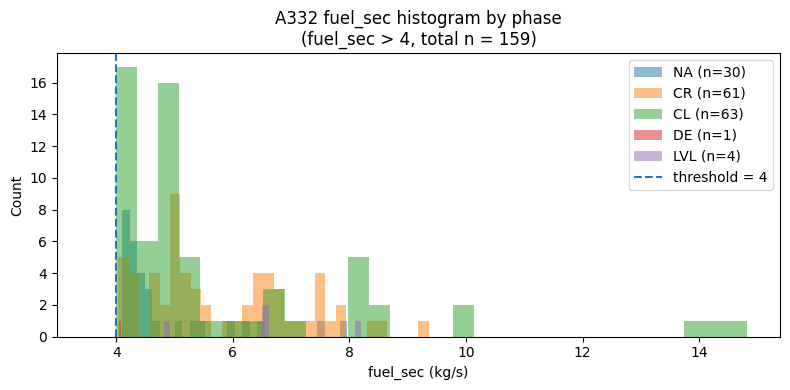

In [26]:
df_b744 = plot_fuel_hist_for_type(df_train, aircraft_type="A332", threshold=4)

In [11]:
import pandas as pd
import os

# Load parquet
path = os.path.join("data", "apt.parquet")
airport = pd.read_parquet(path)

# Show the row first (optional)
print(airport.loc[airport["icao"] == "ZGOW"])


      icao  longitude  latitude  elevation
8544  ZGOW   116.5033    23.552       52.0


In [10]:
airport.loc[airport["icao"] == "ZGOW", "elevation"] = 52   # example value
airport.to_parquet(path, index=False)


In [ ]:
print()